In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

подготовка изображения

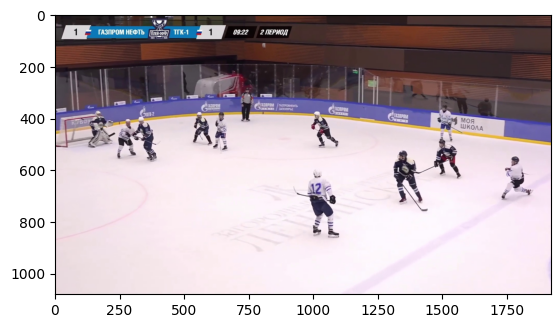

In [65]:
img_path = "../output_videos/color_image.jpg"
#img_path = "../res_puck.png"
image = cv2.imread(img_path)

# преобразуем в нужное цвет. простр-во (из BGR в HSV)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

plt.imshow(image)
plt.show()




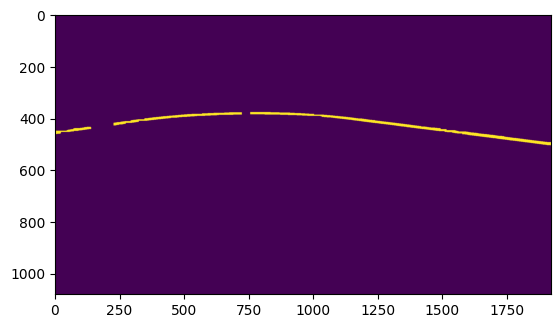

In [66]:
hue_min = np.array((170, 130, 30))
hue_max = np.array((240, 200, 160))

filtered_1 = cv2.inRange(image, hue_min, hue_max)

# заполняем светлые пятна
kernel_b = np.ones((5,5), np.uint8)
filtered = cv2.morphologyEx(filtered_1, cv2.MORPH_OPEN, kernel_b)

# заполняем темные пятна
kernel_w = np.ones((5,30), np.uint8)
filtered = cv2.morphologyEx(filtered, cv2.MORPH_CLOSE, kernel_w)


plt.imshow(filtered)
plt.show()

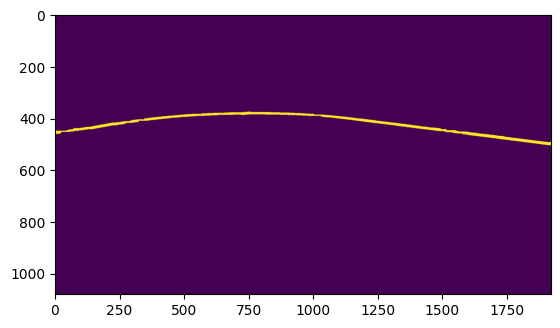

In [82]:
# находим контуры
contours, _ = cv2.findContours(filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# сортируем их по тому, как они расположены (слева-направо)
# contours_sorted = sorted(list(contours), key=lambda x: min(x.tolist(), key=lambda y: y[0][0]))


# находим границы кусков прямой
borders_contours = []
for contour in contours:
    listCon = contour.tolist()
    left_border = min(listCon, key=lambda x: x[0][0])
    right_border = max(listCon, key=lambda x: x[0][0])
    borders_contours.append([left_border, right_border])
        
# сортируем границы по тому, как они расположены на оси x(слева-направо)
borders_contours = sorted(borders_contours)
    
# Отрисовка кусков 
# result1 = image_hsv.copy()
result1 = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
img_show = cv2.drawContours(result1, contours, -1, 255, -1)

# соединяем соседние куски прямыми отрезками
for i in range(len(borders_contours)-1):
    point_1 = borders_contours[i][1][0]
    point_2 = borders_contours[i+1][0][0]

    # костыль, чтобы прямые соединяли чуть ровнее
    point_1[1] -= 3
    point_2[1] += 3

    img_show =  cv2.line(img_show, tuple(point_1), tuple(point_2), 255, 10)


plt.imshow(img_show)
plt.show()

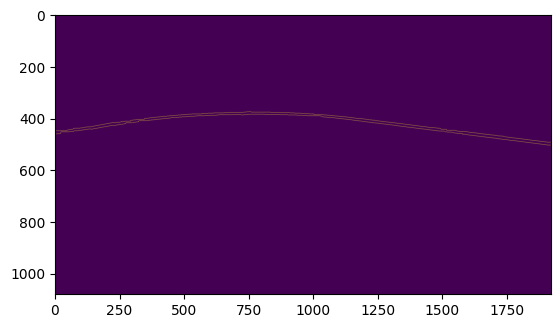

In [85]:


contours, _ = cv2.findContours(img_show, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

result2 = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
img_show2 = cv2.drawContours(result2, contours, -1, 255, 1)


plt.imshow(img_show2)
plt.show()

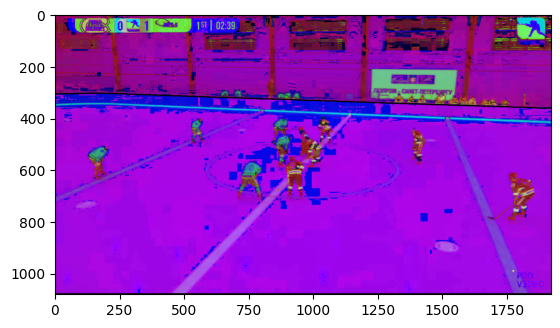

In [401]:
hue_min = np.array((0, 0, 200))
hue_max = np.array((255, 255, 255))

filtered_img1 = cv2.inRange(image_hsv, hue_min, hue_max)

# заполняем светлые пятна
kernel_b = np.ones((10,10), np.uint8)
filtered_img = cv2.morphologyEx(filtered_img1, cv2.MORPH_OPEN, kernel_b)

# заполняем темные пятна
kernel_w = np.ones((20,100), np.uint8)
filtered_img = cv2.morphologyEx(filtered_img, cv2.MORPH_CLOSE, kernel_w)

# находим контуры
contours, _ = cv2.findContours(filtered_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# оставляем контур самого крупного объекта (логично, что это будет лед)
min_area = 500000
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Отрисовка границ
result = image_hsv.copy()
img_show = cv2.drawContours(result, large_contours, -1, (0, 0, 0), 3)

plt.imshow(img_show)
plt.show()


In [230]:
cv2.destroyAllWindows()

разобъем изображение на 2 цветовых кластера

[[244.15789919 230.14203021 236.95827328]
 [ 76.40706263  58.5017306   67.55720626]]


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1080, 1920), dtype=int32)

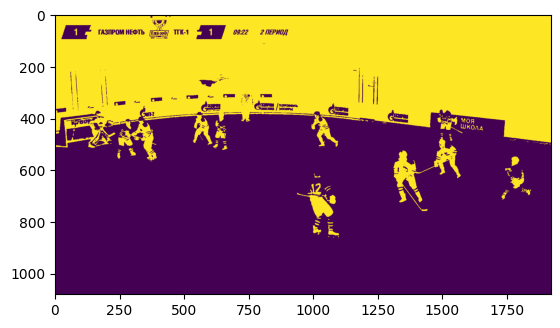

In [17]:
# преобразуем изображение в массив точек
img2d = image.reshape(-1, 3)

# обучим модель кластеризации
kmeans_model = KMeans(n_clusters=2, init="k-means++", n_init=1,  random_state=42)
kmeans_model.fit(img2d)

#получим метки и преобразоем обратно в изображение
labels = kmeans_model.labels_
list_labels = list(labels)
print(kmeans_model.cluster_centers_)

clastered_img = labels.reshape(image.shape[0], image.shape[1])
plt.imshow(clastered_img)
clastered_img




In [5]:
#посмотрим какой кластер является игроком
#очевидно, что по углам изображения будет скорее всего фон
corner_pixels = [clastered_img[0, 0], clastered_img[0, -1], clastered_img[-1, 0], clastered_img[-1, -1]]
backgraund_label = max(corner_pixels, key=corner_pixels.count)
#backgraund_label = max(list_labels, )
player_label = 1 - backgraund_label

# получим цвет игрока
player_color = kmeans_model.cluster_centers_[player_label]
backgraund_color = kmeans_model.cluster_centers_[backgraund_label]
print("игрок", player_label, player_color)
print("фон", backgraund_label, backgraund_color)

print(type(kmeans_model.cluster_centers_[player_label]))

print(corner_pixels)






игрок 1 [69.06714286 54.48714286 63.71714286]
фон 0 [183.39715536 171.38512035 174.68490153]
<class 'numpy.ndarray'>
[np.int32(0), np.int32(0), np.int32(0), np.int32(0)]


In [5]:
# 2 способ определения фона
# найдем фон, как самый яркий кластер 
centers = kmeans_model.cluster_centers_.tolist()
backgraund_color = max(centers, key = lambda x: sum(x))
backgraund_label = centers.index(backgraund_color)

# найдем веса кластеров игрока (нужно для среднего взвешенного) 
labels = kmeans_model.labels_.tolist()
label_pl1, label_pl2 = set(labels) - set([backgraund_label])
w1, w2 = labels.count(label_pl1), labels.count(label_pl2)


# смешиваем краски)
pl_col = np.array([(i*w1 + j*w2)/(w1 + w2) for i, j in zip(centers[label_pl1], centers[label_pl2])])

print(pl_col)


[152.73388203 142.86899863 159.01971879]


In [6]:
centers = np.array(centers)

kmeans_model.predict(centers[1].reshape(1, -1))



array([1], dtype=int32)

In [15]:
d = {1:{'bbox':[1323]}}
d1 = {}
d.get(1, {}).get('bbox', [])

[1323]

In [4]:
Cated_frame = [[] for i in range(6)]
print(Cated_frame)

[[], [], [], [], [], []]


In [3]:
rect = np.zeros((4, 2), dtype = "float32")

In [4]:
rect

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)